In [1]:
from climpyrical.gridding import scale_model_obs
from climpyrical.mask import stratify_coords
from climpyrical.data import read_data, interpolate_dataset, gen_dataset
from climpyrical.rkrig import rkrig_r
from climpyrical.cmd.find_matched_model_vals import add_model_values

from pkg_resources import resource_filename

from sklearn.neighbors import NearestNeighbors
import warnings
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

### Parameters are loaded from config_example.yml
Example configuration from config_example.yml:
```
    paths:
        preprocessed_model_path: /data/results/intermediate/preprocessed_netcdf/
    RL50:
        station_dv: "RL50 (kPa)"
        station_path: 'data/station_inputs/Interim_snow_rain_load_LR_composite_stations_tbd_v4.csv'
        input_model_path: 'data/model_inputs/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
        medians: 
            value: 0.4
            action: "multiply"
        fill_glaciers: True
```

In [2]:
# parameter cell

In [3]:
# Parameters
name = "RL50"
station_dv = "RL50 (kPa)"
station_path = "data/station_inputs/sl50_rl50_for_maps.csv"
input_model_path = (
    "data/model_inputs/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc"
)
medians = {"value": 0.3, "action": "multiply"}
fill_glaciers = True
output_notebook_path = "/data/results/intermediate/notebooks/"
preprocessed_model_path = "/data/results/intermediate/preprocessed_netcdf/"
preprocessed_stations_path = "/data/results/intermediate/preprocessed_stations/"
output_reconstruction_path = "/data/results/netcdf/"
output_tables_path = "/data/results/TableC2/"
output_figure_path = "/data/results/figures/"
mask_path = "data/masks/canada_mask_rp.nc"
north_mask_path = "data/masks/canada_mask_north_rp.nc"
nbcc_loc_path = "data/station_inputs/NBCC_2020_new_coords.xlsm"
nbcc_median_correction = True


Load processed moded, target canada-only mask, and the Upper Artic Area mask 

In [4]:
# Hard coded CanRCM4 upper model domain rlat
dsold_max = 28.15999984741211

ds = read_data(resource_filename("climpyrical", f"{preprocessed_model_path}{name}.nc"))
(dv, ) = ds.data_vars

mask = read_data(
    resource_filename(
        'climpyrical',
        mask_path
    ))['mask'].values

northern_mask = read_data(
    resource_filename(
        'climpyrical',
        north_mask_path
    )
)['mask'].values

rlon, rlat = np.meshgrid(ds.rlon, ds.rlat)

Load processed station data

In [5]:
df = pd.read_csv(
    resource_filename(
        "climpyrical",
        f"{preprocessed_stations_path}{name}.csv"
    ), 
    index_col=False
)
df.head(3)

,irlat,irlon,RL50 (kPa),rlat,rlon,lat,lon,elev (m),station_name,province,model_values,ratio
0,558,1009,0.402,-4.286849,10.373390,42.2756,-82.9556,190.0,WINDSOR A,ON,0.282396,1.192893
1,559,1009,0.484,-4.227125,10.379271,42.3333,-82.9333,188.0,WINDSOR RIVERSIDE,ON,0.281812,1.439196
2,576,1017,0.389,-3.494586,10.713492,42.9922,-82.3047,181.0,SARNIA AIRPORT,ON,0.286172,1.139084


In [6]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    K = 273.15
    df[station_dv] += K
    df["model_values"] += K
    ds[dv] += K

Separate stations into beyond and within the model domain

In [7]:
df_north = df[df.rlat > dsold_max].copy()
df_south = df[df.rlat <= dsold_max].copy()

north_index = df_north.index.values
south_index = df_south.index.values

Check for sets of stations that are identical. This would produce idential windows over a geographic area and disproportionately weight them in the averaged ratio field.

In [8]:
X_distances = np.stack([np.deg2rad(df_south.lat.values), np.deg2rad(df_south.lon.values)])
nbrs = NearestNeighbors(n_neighbors=30, metric="haversine").fit(
    X_distances.T
)

# Order independent window checkers
# only uses windows that are not-identical

dist, ind = nbrs.kneighbors(X_distances.T)
good_i = []
list_of_sets = []
count = 0 
for i in range(df_south.shape[0]):
    list_of_sets.append(df_south[["lon", "lat", station_dv]].iloc[ind[i]].values)
    if i+1-count == np.unique(list_of_sets, axis=0).shape[0]:
        good_i.append(i)
    else:
        warning.warn("There are identical windows!")
        count += 1 

df_south = df_south.iloc[good_i]

Calculate the station average in the UAA

In [9]:
UAA_station_mean = np.nanmean(df[station_dv][df.rlat > dsold_max-1])
UAA_station_mean

0.081

Use the best tolerance scaling to scale the model values. The ratio is already automatically scaled.

In [10]:
model_vals = df.model_values
station_vals = df[station_dv]

ratio, best_tol = scale_model_obs(df.model_values, station_vals)

# apply correction
model_vals_corrected = (model_vals/best_tol)
mean_corrected = (ds[dv].values/best_tol)

Perform ratio kriging on the set of stations below the maximum CanRCM4 native domain.

In [11]:
ratio_field = rkrig_r(df_south, 30, ds, station_dv)
ratio_field[~mask] = np.nan

  0%|          | 0/411 [00:00<?, ?it/s]

  0%|          | 2/411 [00:00<02:00,  3.39it/s]

  1%|          | 3/411 [00:01<02:25,  2.80it/s]

  1%|          | 4/411 [00:01<02:41,  2.52it/s]

  1%|          | 5/411 [00:02<02:53,  2.34it/s]

  1%|▏         | 6/411 [00:02<03:11,  2.12it/s]

  2%|▏         | 7/411 [00:03<03:14,  2.08it/s]

  2%|▏         | 8/411 [00:03<03:16,  2.05it/s]

  2%|▏         | 9/411 [00:04<03:19,  2.02it/s]

  2%|▏         | 10/411 [00:04<03:22,  1.98it/s]

  3%|▎         | 11/411 [00:05<03:24,  1.95it/s]

  3%|▎         | 12/411 [00:05<03:32,  1.88it/s]

  3%|▎         | 13/411 [00:06<03:33,  1.87it/s]

  3%|▎         | 14/411 [00:06<03:32,  1.87it/s]

  4%|▎         | 15/411 [00:07<03:30,  1.88it/s]

  4%|▍         | 16/411 [00:07<03:31,  1.87it/s]

  4%|▍         | 17/411 [00:08<03:27,  1.90it/s]

  4%|▍         | 18/411 [00:08<03:28,  1.89it/s]

  5%|▍         | 19/411 [00:09<03:26,  1.90it/s]

  5%|▍         | 20/411 [00:10<03:26,  1.89it/s]

  5%|▌         | 21/411 [00:10<03:27,  1.88it/s]

  5%|▌         | 22/411 [00:11<03:25,  1.89it/s]

  6%|▌         | 23/411 [00:11<03:25,  1.89it/s]

  6%|▌         | 24/411 [00:12<03:22,  1.91it/s]

  6%|▌         | 25/411 [00:12<03:21,  1.92it/s]

  6%|▋         | 26/411 [00:13<03:22,  1.90it/s]

  7%|▋         | 27/411 [00:13<03:25,  1.87it/s]

  7%|▋         | 28/411 [00:14<03:26,  1.86it/s]

  7%|▋         | 29/411 [00:14<03:29,  1.83it/s]

  7%|▋         | 30/411 [00:15<03:26,  1.84it/s]

  8%|▊         | 31/411 [00:15<03:29,  1.82it/s]

  8%|▊         | 32/411 [00:16<03:30,  1.80it/s]

  8%|▊         | 33/411 [00:17<03:26,  1.83it/s]

  8%|▊         | 34/411 [00:17<03:26,  1.83it/s]

  9%|▊         | 35/411 [00:18<03:23,  1.85it/s]

  9%|▉         | 36/411 [00:18<03:22,  1.85it/s]

  9%|▉         | 37/411 [00:19<03:21,  1.85it/s]

  9%|▉         | 38/411 [00:19<03:25,  1.81it/s]

  9%|▉         | 39/411 [00:20<03:23,  1.83it/s]

 10%|▉         | 40/411 [00:20<03:21,  1.85it/s]

 10%|▉         | 41/411 [00:21<03:17,  1.88it/s]

 10%|█         | 42/411 [00:21<03:20,  1.84it/s]

 10%|█         | 43/411 [00:22<03:17,  1.87it/s]

 11%|█         | 44/411 [00:23<03:17,  1.86it/s]

 11%|█         | 45/411 [00:23<03:23,  1.80it/s]

 11%|█         | 46/411 [00:24<03:23,  1.80it/s]

 11%|█▏        | 47/411 [00:24<03:17,  1.84it/s]

 12%|█▏        | 48/411 [00:25<03:15,  1.86it/s]

 12%|█▏        | 49/411 [00:25<03:17,  1.83it/s]

 12%|█▏        | 50/411 [00:26<03:18,  1.82it/s]

 12%|█▏        | 51/411 [00:26<03:12,  1.87it/s]

 13%|█▎        | 52/411 [00:27<03:11,  1.88it/s]

 13%|█▎        | 53/411 [00:27<03:12,  1.86it/s]

 13%|█▎        | 54/411 [00:28<03:14,  1.83it/s]

 13%|█▎        | 55/411 [00:29<03:16,  1.81it/s]

 14%|█▎        | 56/411 [00:29<03:17,  1.80it/s]

 14%|█▍        | 57/411 [00:30<03:17,  1.79it/s]

 14%|█▍        | 58/411 [00:30<03:13,  1.82it/s]

 14%|█▍        | 59/411 [00:31<03:09,  1.85it/s]

 15%|█▍        | 60/411 [00:31<03:14,  1.80it/s]

 15%|█▍        | 61/411 [00:32<03:13,  1.81it/s]

 15%|█▌        | 62/411 [00:32<03:12,  1.82it/s]

 15%|█▌        | 63/411 [00:33<03:09,  1.84it/s]

 16%|█▌        | 64/411 [00:33<03:11,  1.81it/s]

 16%|█▌        | 65/411 [00:34<03:11,  1.81it/s]

 16%|█▌        | 66/411 [00:35<03:08,  1.84it/s]

 16%|█▋        | 67/411 [00:35<03:04,  1.86it/s]

 17%|█▋        | 68/411 [00:36<03:05,  1.85it/s]

 17%|█▋        | 69/411 [00:36<03:02,  1.87it/s]

 17%|█▋        | 70/411 [00:37<03:01,  1.88it/s]

 17%|█▋        | 71/411 [00:37<02:58,  1.91it/s]

 18%|█▊        | 72/411 [00:38<02:58,  1.90it/s]

 18%|█▊        | 73/411 [00:38<02:59,  1.88it/s]

 18%|█▊        | 74/411 [00:39<02:57,  1.89it/s]

 18%|█▊        | 75/411 [00:39<03:01,  1.86it/s]

 18%|█▊        | 76/411 [00:40<02:57,  1.89it/s]

 19%|█▊        | 77/411 [00:40<02:54,  1.91it/s]

 19%|█▉        | 78/411 [00:41<02:56,  1.89it/s]

 19%|█▉        | 79/411 [00:41<02:54,  1.91it/s]

 19%|█▉        | 80/411 [00:42<02:53,  1.91it/s]

 20%|█▉        | 81/411 [00:42<02:50,  1.94it/s]

 20%|█▉        | 82/411 [00:43<02:50,  1.93it/s]

 20%|██        | 83/411 [00:44<02:52,  1.90it/s]

 20%|██        | 84/411 [00:44<02:51,  1.91it/s]

 21%|██        | 85/411 [00:45<02:50,  1.91it/s]

 21%|██        | 86/411 [00:45<02:49,  1.92it/s]

 21%|██        | 87/411 [00:46<02:48,  1.92it/s]

 21%|██▏       | 88/411 [00:46<02:49,  1.91it/s]

 22%|██▏       | 89/411 [00:47<02:48,  1.91it/s]

 22%|██▏       | 90/411 [00:47<02:49,  1.90it/s]

 22%|██▏       | 91/411 [00:48<02:48,  1.90it/s]

 22%|██▏       | 92/411 [00:48<02:53,  1.84it/s]

 23%|██▎       | 93/411 [00:49<02:52,  1.84it/s]

 23%|██▎       | 94/411 [00:49<02:51,  1.84it/s]

 23%|██▎       | 95/411 [00:50<02:47,  1.89it/s]

 23%|██▎       | 96/411 [00:50<02:45,  1.90it/s]

 24%|██▎       | 97/411 [00:51<02:43,  1.92it/s]

 24%|██▍       | 98/411 [00:52<04:09,  1.26it/s]

 24%|██▍       | 99/411 [00:53<03:41,  1.41it/s]

 24%|██▍       | 100/411 [00:53<03:23,  1.53it/s]

 25%|██▍       | 101/411 [00:54<03:10,  1.63it/s]

 25%|██▍       | 102/411 [00:54<03:00,  1.71it/s]

 25%|██▌       | 103/411 [00:55<02:54,  1.77it/s]

 25%|██▌       | 104/411 [00:56<02:57,  1.73it/s]

 26%|██▌       | 105/411 [00:56<02:51,  1.78it/s]

 26%|██▌       | 106/411 [00:58<04:25,  1.15it/s]

 26%|██▌       | 107/411 [00:58<04:00,  1.27it/s]

 26%|██▋       | 108/411 [00:59<03:39,  1.38it/s]

 27%|██▋       | 109/411 [00:59<03:23,  1.48it/s]

 27%|██▋       | 110/411 [01:00<03:12,  1.56it/s]

 27%|██▋       | 111/411 [01:00<03:03,  1.63it/s]

 27%|██▋       | 112/411 [01:01<02:52,  1.73it/s]

 27%|██▋       | 113/411 [01:02<02:48,  1.77it/s]

 28%|██▊       | 114/411 [01:02<02:45,  1.80it/s]

 28%|██▊       | 115/411 [01:03<02:41,  1.83it/s]

 28%|██▊       | 116/411 [01:03<02:43,  1.81it/s]

 28%|██▊       | 117/411 [01:04<02:39,  1.84it/s]

 29%|██▊       | 118/411 [01:04<02:40,  1.82it/s]

 29%|██▉       | 119/411 [01:05<02:38,  1.84it/s]

 29%|██▉       | 120/411 [01:05<02:34,  1.88it/s]

 29%|██▉       | 121/411 [01:06<02:33,  1.89it/s]

 30%|██▉       | 122/411 [01:06<02:34,  1.87it/s]

 30%|██▉       | 123/411 [01:07<02:32,  1.89it/s]

 30%|███       | 124/411 [01:07<02:32,  1.88it/s]

 30%|███       | 125/411 [01:08<02:32,  1.88it/s]

 31%|███       | 126/411 [01:09<03:35,  1.32it/s]

 31%|███       | 127/411 [01:10<03:17,  1.44it/s]

 31%|███       | 128/411 [01:10<03:03,  1.55it/s]

 31%|███▏      | 129/411 [01:11<02:52,  1.63it/s]

 32%|███▏      | 130/411 [01:11<02:46,  1.69it/s]

 32%|███▏      | 131/411 [01:13<04:16,  1.09it/s]

 32%|███▏      | 132/411 [01:14<03:46,  1.23it/s]

 32%|███▏      | 133/411 [01:14<03:22,  1.37it/s]

 33%|███▎      | 134/411 [01:16<04:23,  1.05it/s]

 33%|███▎      | 135/411 [01:16<03:46,  1.22it/s]

 33%|███▎      | 136/411 [01:17<03:20,  1.37it/s]

 33%|███▎      | 137/411 [01:17<03:02,  1.50it/s]

 34%|███▎      | 138/411 [01:18<02:51,  1.59it/s]

 34%|███▍      | 139/411 [01:18<02:43,  1.66it/s]

 34%|███▍      | 140/411 [01:19<02:44,  1.64it/s]

 34%|███▍      | 141/411 [01:19<02:38,  1.70it/s]

 35%|███▍      | 142/411 [01:20<02:34,  1.75it/s]

 35%|███▍      | 143/411 [01:21<02:33,  1.75it/s]

 35%|███▌      | 144/411 [01:21<02:26,  1.82it/s]

 35%|███▌      | 145/411 [01:22<02:25,  1.83it/s]

 36%|███▌      | 146/411 [01:22<02:23,  1.84it/s]

 36%|███▌      | 147/411 [01:23<02:24,  1.83it/s]

 36%|███▌      | 148/411 [01:23<02:21,  1.86it/s]

 36%|███▋      | 149/411 [01:24<02:19,  1.87it/s]

 36%|███▋      | 150/411 [01:25<03:28,  1.25it/s]

 37%|███▋      | 151/411 [01:26<03:12,  1.35it/s]

 37%|███▋      | 152/411 [01:26<02:55,  1.48it/s]

 37%|███▋      | 153/411 [01:27<02:44,  1.57it/s]

 37%|███▋      | 154/411 [01:27<02:36,  1.64it/s]

 38%|███▊      | 155/411 [01:29<03:30,  1.22it/s]

 38%|███▊      | 156/411 [01:30<04:12,  1.01it/s]

 38%|███▊      | 157/411 [01:32<05:10,  1.22s/it]

 38%|███▊      | 158/411 [01:32<04:18,  1.02s/it]

 39%|███▊      | 159/411 [01:34<04:40,  1.11s/it]

 39%|███▉      | 160/411 [01:34<03:57,  1.06it/s]

 39%|███▉      | 161/411 [01:35<03:27,  1.21it/s]

 39%|███▉      | 162/411 [01:35<03:06,  1.33it/s]

 40%|███▉      | 163/411 [01:36<02:54,  1.42it/s]

 40%|███▉      | 164/411 [01:37<03:30,  1.17it/s]

 40%|████      | 165/411 [01:38<03:05,  1.33it/s]

 40%|████      | 166/411 [01:38<02:49,  1.45it/s]

 41%|████      | 167/411 [01:39<02:52,  1.42it/s]

 41%|████      | 168/411 [01:40<02:39,  1.52it/s]

 41%|████      | 169/411 [01:41<04:02,  1.00s/it]

 41%|████▏     | 170/411 [01:42<03:34,  1.12it/s]

 42%|████▏     | 171/411 [01:43<03:11,  1.25it/s]

 42%|████▏     | 172/411 [01:43<02:57,  1.35it/s]

 42%|████▏     | 173/411 [01:44<02:42,  1.46it/s]

 42%|████▏     | 174/411 [01:44<02:31,  1.56it/s]

 43%|████▎     | 175/411 [01:45<02:23,  1.65it/s]

 43%|████▎     | 176/411 [01:45<02:18,  1.70it/s]

 43%|████▎     | 177/411 [01:46<02:11,  1.78it/s]

 43%|████▎     | 178/411 [01:46<02:10,  1.79it/s]

 44%|████▎     | 179/411 [01:47<02:05,  1.84it/s]

 44%|████▍     | 180/411 [01:47<02:05,  1.84it/s]

 44%|████▍     | 181/411 [01:49<03:20,  1.15it/s]

 44%|████▍     | 182/411 [01:50<02:55,  1.30it/s]

 45%|████▍     | 183/411 [01:51<03:56,  1.04s/it]

 45%|████▍     | 184/411 [01:53<04:28,  1.18s/it]

 45%|████▌     | 185/411 [01:54<04:36,  1.22s/it]

 45%|████▌     | 186/411 [01:55<03:48,  1.02s/it]

 45%|████▌     | 187/411 [01:56<03:55,  1.05s/it]

 46%|████▌     | 188/411 [01:57<04:17,  1.15s/it]

 46%|████▌     | 189/411 [01:59<04:41,  1.27s/it]

 46%|████▌     | 190/411 [01:59<03:51,  1.05s/it]

 46%|████▋     | 191/411 [02:00<04:01,  1.10s/it]

 47%|████▋     | 192/411 [02:01<03:59,  1.09s/it]

 47%|████▋     | 193/411 [02:02<03:22,  1.08it/s]

 47%|████▋     | 194/411 [02:03<02:58,  1.21it/s]

 47%|████▋     | 195/411 [02:03<02:39,  1.35it/s]

 48%|████▊     | 196/411 [02:04<02:31,  1.42it/s]

 48%|████▊     | 197/411 [02:05<03:13,  1.10it/s]

 48%|████▊     | 198/411 [02:06<02:51,  1.24it/s]

 48%|████▊     | 199/411 [02:07<03:39,  1.04s/it]

 49%|████▊     | 200/411 [02:08<03:39,  1.04s/it]

 49%|████▉     | 201/411 [02:09<03:44,  1.07s/it]

 49%|████▉     | 202/411 [02:10<03:11,  1.09it/s]

 49%|████▉     | 203/411 [02:11<03:35,  1.04s/it]

 50%|████▉     | 204/411 [02:13<03:59,  1.16s/it]

 50%|████▉     | 205/411 [02:14<04:31,  1.32s/it]

 50%|█████     | 206/411 [02:15<03:43,  1.09s/it]

 50%|█████     | 207/411 [02:16<04:00,  1.18s/it]

 51%|█████     | 208/411 [02:18<04:16,  1.26s/it]

 51%|█████     | 209/411 [02:18<03:31,  1.05s/it]

 51%|█████     | 210/411 [02:19<03:00,  1.12it/s]

 51%|█████▏    | 211/411 [02:20<02:36,  1.28it/s]

 52%|█████▏    | 212/411 [02:20<02:20,  1.42it/s]

 52%|█████▏    | 213/411 [02:21<02:09,  1.53it/s]

 52%|█████▏    | 214/411 [02:21<02:01,  1.63it/s]

 52%|█████▏    | 215/411 [02:22<01:59,  1.64it/s]

 53%|█████▎    | 216/411 [02:23<02:49,  1.15it/s]

 53%|█████▎    | 217/411 [02:25<03:22,  1.04s/it]

 53%|█████▎    | 218/411 [02:25<02:52,  1.12it/s]

 53%|█████▎    | 219/411 [02:26<02:32,  1.26it/s]

 54%|█████▎    | 220/411 [02:26<02:15,  1.41it/s]

 54%|█████▍    | 221/411 [02:28<02:52,  1.10it/s]

 54%|█████▍    | 222/411 [02:28<02:33,  1.23it/s]

 54%|█████▍    | 223/411 [02:29<02:19,  1.35it/s]

 55%|█████▍    | 224/411 [02:29<02:06,  1.48it/s]

 55%|█████▍    | 225/411 [02:31<03:09,  1.02s/it]

 55%|█████▍    | 226/411 [02:32<02:41,  1.14it/s]

 55%|█████▌    | 227/411 [02:32<02:22,  1.29it/s]

 55%|█████▌    | 228/411 [02:34<02:51,  1.06it/s]

 56%|█████▌    | 229/411 [02:35<03:23,  1.12s/it]

 56%|█████▌    | 230/411 [02:36<03:36,  1.20s/it]

 56%|█████▌    | 231/411 [02:38<03:39,  1.22s/it]

 56%|█████▋    | 232/411 [02:38<03:06,  1.04s/it]

 57%|█████▋    | 233/411 [02:39<02:44,  1.08it/s]

 57%|█████▋    | 234/411 [02:40<03:04,  1.04s/it]

 57%|█████▋    | 235/411 [02:42<03:16,  1.12s/it]

 57%|█████▋    | 236/411 [02:43<03:16,  1.12s/it]

 58%|█████▊    | 237/411 [02:44<03:32,  1.22s/it]

 58%|█████▊    | 238/411 [02:45<03:33,  1.23s/it]

 58%|█████▊    | 239/411 [02:47<03:26,  1.20s/it]

 58%|█████▊    | 240/411 [02:48<03:33,  1.25s/it]

 59%|█████▊    | 241/411 [02:49<03:26,  1.22s/it]

 59%|█████▉    | 242/411 [02:50<03:26,  1.22s/it]

 59%|█████▉    | 243/411 [02:51<02:53,  1.03s/it]

 59%|█████▉    | 244/411 [02:51<02:28,  1.13it/s]

 60%|█████▉    | 245/411 [02:52<02:10,  1.27it/s]

 60%|█████▉    | 246/411 [02:53<02:40,  1.03it/s]

 60%|██████    | 247/411 [02:55<02:57,  1.08s/it]

 60%|██████    | 248/411 [02:55<02:30,  1.08it/s]

 61%|██████    | 249/411 [02:57<03:01,  1.12s/it]

 61%|██████    | 250/411 [02:57<02:32,  1.06it/s]

 61%|██████    | 251/411 [02:59<02:44,  1.03s/it]

 61%|██████▏   | 252/411 [03:00<03:06,  1.17s/it]

 62%|██████▏   | 253/411 [03:01<03:05,  1.18s/it]

 62%|██████▏   | 254/411 [03:02<02:35,  1.01it/s]

 62%|██████▏   | 255/411 [03:02<02:14,  1.16it/s]

 62%|██████▏   | 256/411 [03:04<02:30,  1.03it/s]

 63%|██████▎   | 257/411 [03:05<02:43,  1.06s/it]

 63%|██████▎   | 258/411 [03:06<02:43,  1.07s/it]

 63%|██████▎   | 259/411 [03:07<02:17,  1.10it/s]

 63%|██████▎   | 260/411 [03:07<02:00,  1.25it/s]

 64%|██████▎   | 261/411 [03:08<01:47,  1.40it/s]

 64%|██████▎   | 262/411 [03:09<02:07,  1.17it/s]

 64%|██████▍   | 263/411 [03:10<02:15,  1.09it/s]

 64%|██████▍   | 264/411 [03:11<02:45,  1.12s/it]

 64%|██████▍   | 265/411 [03:13<03:06,  1.28s/it]

 65%|██████▍   | 266/411 [03:15<03:13,  1.34s/it]

 65%|██████▍   | 267/411 [03:15<02:46,  1.15s/it]

 65%|██████▌   | 268/411 [03:16<02:41,  1.13s/it]

 65%|██████▌   | 269/411 [03:18<02:54,  1.23s/it]

 66%|██████▌   | 270/411 [03:19<03:01,  1.29s/it]

 66%|██████▌   | 271/411 [03:21<03:08,  1.35s/it]

 66%|██████▌   | 272/411 [03:22<03:21,  1.45s/it]

 66%|██████▋   | 273/411 [03:24<03:06,  1.35s/it]

 67%|██████▋   | 274/411 [03:25<02:52,  1.26s/it]

 67%|██████▋   | 275/411 [03:26<03:05,  1.36s/it]

 67%|██████▋   | 276/411 [03:27<02:31,  1.13s/it]

 67%|██████▋   | 277/411 [03:27<02:06,  1.06it/s]

 68%|██████▊   | 278/411 [03:28<02:12,  1.00it/s]

 68%|██████▊   | 279/411 [03:30<02:31,  1.15s/it]

 68%|██████▊   | 280/411 [03:31<02:41,  1.23s/it]

 68%|██████▊   | 281/411 [03:33<02:49,  1.30s/it]

 69%|██████▊   | 282/411 [03:34<02:37,  1.22s/it]

 69%|██████▉   | 283/411 [03:36<02:53,  1.35s/it]

 69%|██████▉   | 284/411 [03:37<02:48,  1.33s/it]

 69%|██████▉   | 285/411 [03:38<02:36,  1.24s/it]

 70%|██████▉   | 286/411 [03:39<02:29,  1.19s/it]

 70%|██████▉   | 287/411 [03:40<02:32,  1.23s/it]

 70%|███████   | 288/411 [03:42<02:42,  1.32s/it]

 70%|███████   | 289/411 [03:43<02:31,  1.25s/it]

 71%|███████   | 290/411 [03:43<02:06,  1.04s/it]

 71%|███████   | 291/411 [03:45<02:21,  1.18s/it]

 71%|███████   | 292/411 [03:46<02:18,  1.16s/it]

 71%|███████▏  | 293/411 [03:47<02:21,  1.20s/it]

 72%|███████▏  | 294/411 [03:48<01:57,  1.01s/it]

 72%|███████▏  | 295/411 [03:49<02:02,  1.05s/it]

 72%|███████▏  | 296/411 [03:51<02:20,  1.22s/it]

 72%|███████▏  | 297/411 [03:52<02:29,  1.31s/it]

 73%|███████▎  | 298/411 [03:54<02:38,  1.40s/it]

 73%|███████▎  | 299/411 [03:55<02:37,  1.40s/it]

 73%|███████▎  | 300/411 [03:57<02:36,  1.41s/it]

 73%|███████▎  | 301/411 [03:58<02:48,  1.53s/it]

 73%|███████▎  | 302/411 [04:00<02:43,  1.50s/it]

 74%|███████▎  | 303/411 [04:01<02:41,  1.50s/it]

 74%|███████▍  | 304/411 [04:03<02:36,  1.46s/it]

 74%|███████▍  | 305/411 [04:04<02:41,  1.52s/it]

 74%|███████▍  | 306/411 [04:06<02:36,  1.49s/it]

 75%|███████▍  | 307/411 [04:06<02:07,  1.22s/it]

 75%|███████▍  | 308/411 [04:07<02:00,  1.17s/it]

 75%|███████▌  | 309/411 [04:09<02:00,  1.18s/it]

 75%|███████▌  | 310/411 [04:10<02:01,  1.20s/it]

 76%|███████▌  | 311/411 [04:10<01:40,  1.01s/it]

 76%|███████▌  | 312/411 [04:12<01:45,  1.06s/it]

 76%|███████▌  | 313/411 [04:13<01:46,  1.09s/it]

 76%|███████▋  | 314/411 [04:14<01:54,  1.18s/it]

 77%|███████▋  | 315/411 [04:15<01:51,  1.16s/it]

 77%|███████▋  | 316/411 [04:17<01:54,  1.21s/it]

 77%|███████▋  | 317/411 [04:18<01:59,  1.27s/it]

 77%|███████▋  | 318/411 [04:19<02:03,  1.33s/it]

 78%|███████▊  | 319/411 [04:21<01:57,  1.28s/it]

 78%|███████▊  | 320/411 [04:22<01:54,  1.26s/it]

 78%|███████▊  | 321/411 [04:23<01:49,  1.22s/it]

 78%|███████▊  | 322/411 [04:25<01:58,  1.33s/it]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: In addition: 


R[write to console]: Warning messages:



R[write to console]: 1: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: 2: 


R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :


R[write to console]: 
 


R[write to console]:  libraries ‘/usr/local/lib/R/site-library’, ‘/usr/lib/R/site-library’ contain no packages



R[write to console]: Timing stopped at: 0.221 0.004 0.222



 79%|███████▊  | 323/411 [04:25<01:31,  1.04s/it]

 79%|███████▉  | 324/411 [04:26<01:32,  1.06s/it]

 79%|███████▉  | 325/411 [04:27<01:32,  1.07s/it]

 79%|███████▉  | 326/411 [04:28<01:17,  1.09it/s]

 80%|███████▉  | 327/411 [04:28<01:06,  1.26it/s]

 80%|███████▉  | 328/411 [04:29<01:15,  1.10it/s]

 80%|████████  | 329/411 [04:31<01:21,  1.00it/s]

 80%|████████  | 330/411 [04:32<01:21,  1.01s/it]

 81%|████████  | 331/411 [04:32<01:10,  1.14it/s]

 81%|████████  | 332/411 [04:33<01:19,  1.00s/it]

 81%|████████  | 333/411 [04:34<01:06,  1.17it/s]

 81%|████████▏ | 334/411 [04:36<01:21,  1.05s/it]

 82%|████████▏ | 335/411 [04:37<01:24,  1.11s/it]

 82%|████████▏ | 336/411 [04:37<01:11,  1.05it/s]

 82%|████████▏ | 337/411 [04:38<01:01,  1.21it/s]

 82%|████████▏ | 338/411 [04:39<01:14,  1.02s/it]

 82%|████████▏ | 339/411 [04:41<01:22,  1.15s/it]

 83%|████████▎ | 340/411 [04:42<01:24,  1.19s/it]

 83%|████████▎ | 341/411 [04:43<01:23,  1.20s/it]

 83%|████████▎ | 342/411 [04:45<01:23,  1.22s/it]

 83%|████████▎ | 343/411 [04:46<01:28,  1.31s/it]

 84%|████████▎ | 344/411 [04:47<01:12,  1.09s/it]

 84%|████████▍ | 345/411 [04:47<01:00,  1.08it/s]

 84%|████████▍ | 346/411 [04:49<01:12,  1.11s/it]

 84%|████████▍ | 347/411 [04:50<01:19,  1.25s/it]

 85%|████████▍ | 348/411 [04:51<01:05,  1.04s/it]

 85%|████████▍ | 349/411 [04:53<01:20,  1.29s/it]

 85%|████████▌ | 350/411 [04:54<01:09,  1.14s/it]

 85%|████████▌ | 351/411 [04:54<00:57,  1.04it/s]

 86%|████████▌ | 352/411 [04:56<01:08,  1.15s/it]

 86%|████████▌ | 353/411 [04:56<00:56,  1.03it/s]

 86%|████████▌ | 354/411 [04:58<01:00,  1.07s/it]

 86%|████████▋ | 355/411 [04:58<00:50,  1.10it/s]

 87%|████████▋ | 356/411 [05:00<01:00,  1.10s/it]

 87%|████████▋ | 357/411 [05:01<01:08,  1.27s/it]

 87%|████████▋ | 358/411 [05:02<00:56,  1.07s/it]

 87%|████████▋ | 359/411 [05:03<01:00,  1.17s/it]

 88%|████████▊ | 360/411 [05:05<01:09,  1.37s/it]

 88%|████████▊ | 361/411 [05:06<01:08,  1.38s/it]

 88%|████████▊ | 362/411 [05:08<01:04,  1.32s/it]

 88%|████████▊ | 363/411 [05:10<01:11,  1.48s/it]

 89%|████████▊ | 364/411 [05:10<00:56,  1.21s/it]

 89%|████████▉ | 365/411 [05:11<00:46,  1.02s/it]

 89%|████████▉ | 366/411 [05:12<00:46,  1.04s/it]

 89%|████████▉ | 367/411 [05:12<00:39,  1.13it/s]

 90%|████████▉ | 368/411 [05:14<00:44,  1.02s/it]

 90%|████████▉ | 369/411 [05:15<00:46,  1.11s/it]

 90%|█████████ | 370/411 [05:16<00:47,  1.15s/it]

 90%|█████████ | 371/411 [05:18<00:49,  1.24s/it]

 91%|█████████ | 372/411 [05:19<00:52,  1.35s/it]

 91%|█████████ | 373/411 [05:21<00:52,  1.38s/it]

 91%|█████████ | 374/411 [05:22<00:54,  1.47s/it]

 91%|█████████ | 375/411 [05:24<00:51,  1.42s/it]

 91%|█████████▏| 376/411 [05:25<00:49,  1.40s/it]

 92%|█████████▏| 377/411 [05:26<00:46,  1.37s/it]

 92%|█████████▏| 378/411 [05:28<00:47,  1.44s/it]

 92%|█████████▏| 379/411 [05:29<00:47,  1.47s/it]

 92%|█████████▏| 380/411 [05:31<00:43,  1.39s/it]

 93%|█████████▎| 381/411 [05:32<00:40,  1.34s/it]

 93%|█████████▎| 382/411 [05:33<00:40,  1.39s/it]

 93%|█████████▎| 383/411 [05:35<00:40,  1.45s/it]

 93%|█████████▎| 384/411 [05:36<00:39,  1.45s/it]

 94%|█████████▎| 385/411 [05:38<00:40,  1.56s/it]

 94%|█████████▍| 386/411 [05:40<00:38,  1.53s/it]

 94%|█████████▍| 387/411 [05:42<00:42,  1.77s/it]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: Timing stopped at: 0.36 0.004 0.364



 94%|█████████▍| 388/411 [05:43<00:32,  1.39s/it]

 95%|█████████▍| 389/411 [05:44<00:31,  1.44s/it]

 95%|█████████▍| 390/411 [05:46<00:30,  1.44s/it]

 95%|█████████▌| 391/411 [05:47<00:30,  1.50s/it]

 95%|█████████▌| 392/411 [05:50<00:33,  1.75s/it]

 96%|█████████▌| 393/411 [05:51<00:29,  1.65s/it]

 96%|█████████▌| 394/411 [05:52<00:26,  1.57s/it]

 96%|█████████▌| 395/411 [05:54<00:25,  1.58s/it]

 96%|█████████▋| 396/411 [05:56<00:24,  1.66s/it]

 97%|█████████▋| 397/411 [05:57<00:21,  1.55s/it]

 97%|█████████▋| 398/411 [05:58<00:19,  1.50s/it]

 97%|█████████▋| 399/411 [06:01<00:20,  1.67s/it]

 97%|█████████▋| 400/411 [06:03<00:20,  1.84s/it]

 98%|█████████▊| 401/411 [06:06<00:22,  2.29s/it]

 98%|█████████▊| 402/411 [06:08<00:19,  2.18s/it]

 98%|█████████▊| 403/411 [06:11<00:20,  2.54s/it]

 98%|█████████▊| 404/411 [06:13<00:16,  2.35s/it]

 99%|█████████▊| 405/411 [06:17<00:16,  2.67s/it]

 99%|█████████▉| 406/411 [06:20<00:14,  2.89s/it]

 99%|█████████▉| 407/411 [06:22<00:10,  2.66s/it]

 99%|█████████▉| 408/411 [06:25<00:07,  2.57s/it]

R[write to console]: Error in solve.default(qr.R(qr.VT)) : 
  Lapack routine dgesv: system is exactly singular: U[1,1] = 0



R[write to console]: Timing stopped at: 0.544 0 0.545



100%|█████████▉| 409/411 [06:25<00:04,  2.00s/it]

100%|█████████▉| 410/411 [06:29<00:02,  2.54s/it]

100%|██████████| 411/411 [06:32<00:00,  2.71s/it]

100%|██████████| 411/411 [06:35<00:00,  1.04it/s]

Select the UAA strip to sample the reconstruction values from.

In [12]:
selection = ~np.isnan(ds[dv].where((ds.lat > 72.) & (ds.lat < 73) & (ds.lon - 360 < -75) & (ds.lon - 360 > -127)))

Fill and reconstruct the ratio field.

In [13]:
nanmask = ~np.isnan(ratio_field)

points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_points = np.stack([rlon[nanmask^mask], rlat[nanmask^mask]]).T

# We treat TJul2.5 and TwJul2.5 slightly differently than the other DVs
# since an artefact appears in SW Yukon in the CanRCM4 models. Since
# stations happen to be close to coastlines for this DV, we directly
# fill with the nearest reconstructed value, as opposed to the ratio value for 
# the remaining DVs
if station_dv == "TJul2.5 (degC)" or station_dv == "TwJul2.5 (degC)":
    reconstructed_field = ratio_field*mean_corrected.copy()
    target_values = reconstructed_field[nanmask]
    reconstructed_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
else:
    target_values = ratio_field[nanmask]
    ratio_field[nanmask^mask] = interpolate_dataset(points, target_values, target_points, 'nearest')
    reconstructed_field = ratio_field*mean_corrected.copy()

reconstructed_field_strip_mean = np.nanmean(reconstructed_field[selection])
combined_ratio_station_mean = np.mean([reconstructed_field_strip_mean, UAA_station_mean])
reconstructed_field[northern_mask] = combined_ratio_station_mean

Compare kriged ratio values at station grids, with the original ratio values at station krids

<AxesSubplot:title={'center':'RL50 Distributions of Results'}, xlabel='Ratios at Station Grid Cells (i)'>

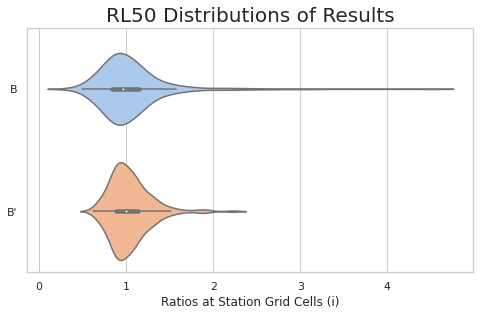

In [14]:
import seaborn as sns

sns.set_theme(style="whitegrid")

fig, ax = plt.subplots(figsize=(8, 4.5))

violindata = np.concatenate([df.ratio, ratio_field[df.irlat, df.irlon]])

b_str = ["B" for x in df.ratio.values]
bp_str = ["B'" for x in ratio_field[df.irlat, df.irlon]]

vstrings = np.concatenate([b_str, bp_str])
vdf = pd.DataFrame({"Ratios at Station Grid Cells (i)": violindata, '': vstrings})

ax.set_title(f"{name} Distributions of Results", fontsize=20)
sns.violinplot(ax=ax, x="Ratios at Station Grid Cells (i)", y='', data=vdf, palette=sns.color_palette('pastel'))

Summarize reconstruction stats

In [15]:
print(
    "Northern fill value:"
    "\n"
    "Reconstruction", reconstructed_field_strip_mean,
    "\n"
    "UAA_station_mean", UAA_station_mean,
    "\n"
    "Combined", combined_ratio_station_mean
)

Northern fill value:
Reconstruction 0.09762617055962783 
UAA_station_mean 0.081 
Combined 0.08931308527981391


Convert back to degC if K was used in previous steps. Generate dataset.

In [16]:
if ds[dv].attrs["units"] == "degC" and "degC" in station_dv:
    print("Convert back to degC")
    K = 273.15 # K
    reconstructed_field -= K
    df[station_dv] -= K
#     ds[dv].attrs["units"] = "degC"

ds_recon = gen_dataset(dv, reconstructed_field, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

# Load in NBCC Tables for Comparisons

In [17]:
nrc_path = resource_filename("climpyrical", nbcc_loc_path)
df_nrc = pd.read_excel(nrc_path).iloc[:-1]

# fill problem values with better values from 2015
id_typo = df_nrc[(df_nrc['2020 Longitude'] > 0) | (df_nrc['2020 Latitude'] < 40)].index
df_nrc.loc[id_typo, '2020 Longitude'] = df_nrc['2015 Long.'].values[id_typo]
df_nrc.loc[id_typo, '2020 Latitude'] = df_nrc['2015 Lat.'].values[id_typo]

# process to get the model values
df_nrc.rename(columns={"2020 Longitude": "lon",
                      "2020 Latitude": "lat"})

df_nrc_matched = pd.DataFrame(
    {
     'Location': df_nrc.Location, 
     'Prov': df_nrc.Prov,
     "2020 Elev (m)": df_nrc["2020 Elev (m)"],
     'lon': df_nrc['2020 Longitude'], 
     'lat': df_nrc['2020 Latitude']
     }
    
)

__This step aims to correct the final field to the NBCC 2015 results.__

This is configurable by setting `nbcc_median_correction` to True or False.

1) Find the median of these values. Compute the difference, d = median(R) - median(NRC), and ratio, f = median(R)/median(NRC) 

2) For the non-temperature DVs and HDD, apply the multiplicative correction (1/f)*R_j over the entire reconstruction grid. For the temperature DVs, apply the correction as R_j - d

In [18]:
value = medians["value"]
action = medians["action"]

if action != "add" and action != "multiply" and action != "None":
    raise ValueError("Please provide either add or multiply or None actions in config.")

    
dfp = add_model_values(ds=ds_recon, df=df_nrc_matched)
reconstructed_field_med = ds_recon[dv].values

if nbcc_median_correction:
    if value != "None" or action != "None":
#         med_pcic = np.nanmedian(dfp["model_values"])
        med_pcic = np.nanmean(dfp["model_values"])

        if action == "multiply":
            fr = med_pcic/value
            reconstructed_field_med = (1/fr)*reconstructed_field_med
            print("f:", fr)
        if action == "add":
            d = med_pcic - value
            reconstructed_field_med = reconstructed_field_med - d
            print("d:", d)

INFO:root:Detect units: kPa


INFO:root:rlat or rlon not detected in input file.converting assumes WGS84 coords to rotated pole


INFO:root:Matching coordinates now


INFO:root:Locating corresponding model valuesInterpolating to nearest if matched model value is NaN


f: 1.2197382119178226


Re-create dataset if median correction applied

In [19]:
ds_recon = gen_dataset(dv, reconstructed_field_med, ds.rlat, ds.rlon, ds.lat, ds.lon, unit=ds[dv].attrs["units"])

Populate with headers from the input processed model.

In [20]:
if ds.attrs:
    all_keys = set(ds_recon.variables).union(set(ds_recon.dims))
    for key in all_keys:
        ds_recon[key].attrs = ds[key].attrs
    attr_dict = ds.attrs
    attr_dict["Climpyrical"] = (
        "CanRCM4 Reconstruction contains"
        "hybrid station and model data using"
        "Climpyrical (https://github.com/pacificclimate/climpyrical)"
    )

    ds_recon.attrs = attr_dict
else:
    raise warnings.warn("No attributes detected in dataset file")

In [21]:
ds_recon.to_netcdf(
    resource_filename(
        "climpyrical",
        f"{output_reconstruction_path}{name}_reconstruction.nc"
    ),
    mode="w"
)